# モデルの学習

In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import time

In [2]:
DATAPATH = "../../../data/DBLP/"
OUTPUTPATH = "../../../result/aminer/"

In [3]:
with open(DATAPATH + "keywords_delete_similar_words.txt") as f:
    keywords = list(map(lambda x: x.replace("\n", ""), f.readlines()))
key_sets = set(keywords)
len(keywords), keywords[0]

(2276, '3d imaging')

In [4]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import lightgbm as lgb #LightGBM
from sklearn.metrics import mean_squared_error
from sklearn import utils

from scipy.stats import pearsonr

In [5]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2276, 2276, 23), (2276, 2276), (2276, 2276, 23), (2276, 2276))

In [6]:
N = train_x.shape[0]
M = train_x.shape[1]
N, M

(2276, 2276)

In [7]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2588950, 23), (2588950,), (2588950, 23), (2588950,))

In [8]:
P = train_x.shape[0]
P

2588950

In [9]:
model = lgb.LGBMRegressor()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))


フィッティング時間: 3.2092527337372303
スコア時間: 1.1146294064819813


In [10]:
result_detail = model.predict(test_x)

In [11]:
result = model.predict(test_x)
result_before = model.predict(train_x)
result.shape, result_before.shape

((2588950,), (2588950,))

In [12]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 8.341, MSE: 69.578, 相関係数: 0.902


In [13]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 5.904, MSE: 34.859, 相関係数: 0.536


In [14]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=False)
df["実測順位"] = df["実測"].rank(ascending=False)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.23

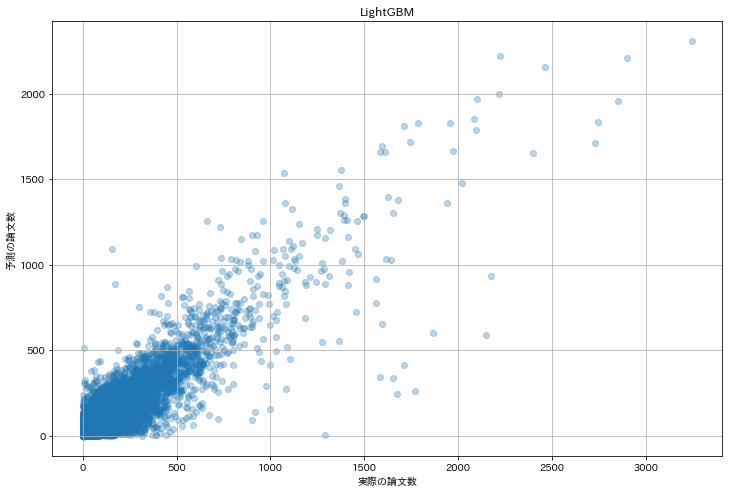

In [15]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
# fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

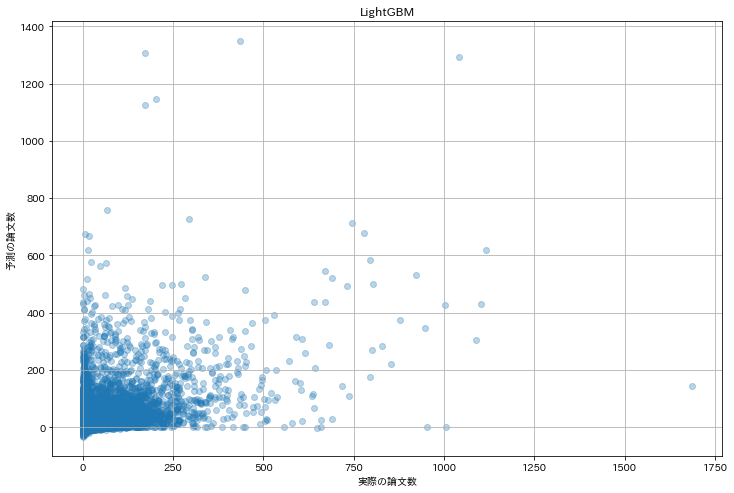

In [16]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

In [17]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = result_detail
for i in range(N):
    for j in range(N):
        if x[i][j] > 400:
            print(i, j, word_matrix[i][j], correct_matrix[i][j], x[i][j])

39 149 ['algorithm' 'bioinformatics'] 13.0 618.8997057273574
39 500 ['algorithm' 'design'] 171.0 1307.8015310789922
39 702 ['algorithm' 'experimentation'] 68.0 759.8953565884251
39 1268 ['algorithm' 'microarrays'] 1.0 483.160748151028
39 1525 ['algorithm' 'performance'] 203.0 1145.22470411236
149 163 ['bioinformatics' 'biomedical research'] 6.0 676.6193396913419
149 842 ['bioinformatics' 'genomics'] 283.0 450.6538838284967
149 1268 ['bioinformatics' 'microarrays'] 3.0 461.9768511872702
208 2024 ['capacitors' 'switches'] 669.0 436.3085668416538
251 1833 ['cloud computing' 'servers'] 803.0 499.1230921286006
251 2203 ['cloud computing' 'virtual machine'] 124.0 428.6645854875309
251 2206 ['cloud computing' 'virtualisation'] 271.0 501.97608511814536
261 1167 ['cmos integrated circuits' 'logic gate'] 26.0 404.1530910236823
271 272 ['cognitive radio' 'cognitive radio networks'] 11.0 440.3993218547467
319 1217 ['computational model' 'mathematical models'] 1003.0 427.47198907902475
416 649 ['cr

In [18]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if correct_matrix[i][j] < -1500:
            print(i, j, word_matrix[i][j], correct_matrix[i][j])

In [19]:
# # weight = np.load(DATAPATH + "weight.npy")
# weight = np.where(train_y == 0.0, True, False) # if target == 0 : True else: False
# weight_inv = np.where(weight, False, True) # if target == 0 : False else: True

# # 0と1以上のデータを同数にする
# train_x_0, train_y_0 = train_x[weight], train_y[weight]
# train_x_1, train_y_1 = train_x[weight_inv], train_y[weight_inv]
# train_x_0, train_y_0 = utils.shuffle(train_x_0, train_y_0)
# train_x_0, train_y_0 = train_x_0[:len(train_x_1)], train_y_0[:len(train_y_1)]
# train_x, train_y = np.concatenate([train_x_0, train_x_1]), np.concatenate([train_y_0, train_y_1])

# print(train_x.shape, train_y.shape)
# print("0のデータ数: {}, 1以上のデータ数: {}".format(len(train_x_0), len(train_x_1)))

# 人気度

In [20]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y_diff.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y_diff.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2276, 2276, 23), (2276, 2276), (2276, 2276, 23), (2276, 2276))

In [21]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2588950, 23), (2588950,), (2588950, 23), (2588950,))

In [22]:
model = lgb.LGBMRegressor()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))
result = model.predict(test_x)
result_before = model.predict(train_x)

フィッティング時間: 3.0833119601011276
スコア時間: 0.8382765725255013


In [23]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 8.594, MSE: 73.852, 相関係数: 0.858


In [24]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 7.888, MSE: 62.214, 相関係数: 0.891


In [25]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=True)
df["実測順位"] = df["実測"].rank(ascending=True)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.65

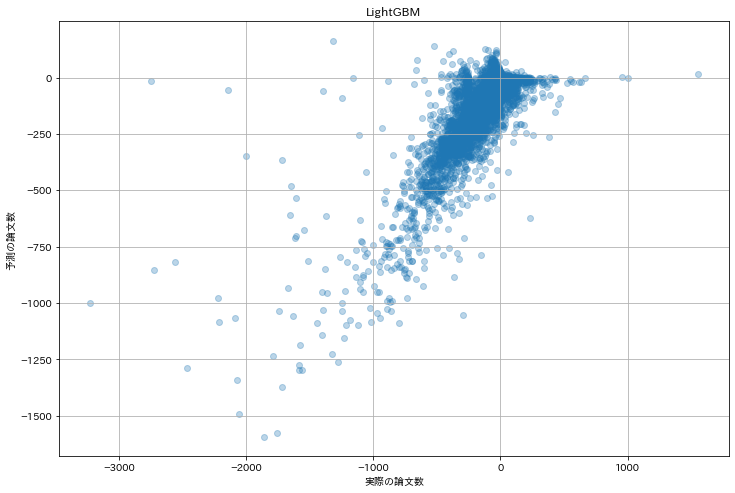

In [26]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
fig.savefig(OUTPUTPATH+"img/gbm_diff.png")
fig.show()

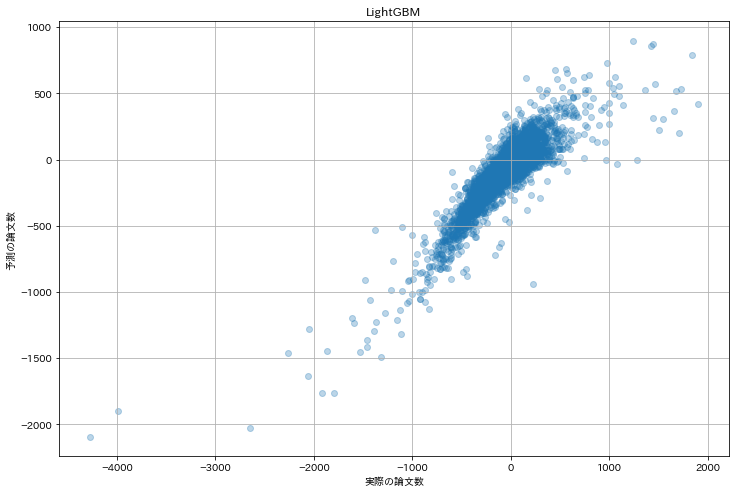

In [27]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
# fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

In [29]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if x[i][j] < -1000:
            print(i, j, word_matrix[i][j], correct_matrix[i][j],x[i][j])

10 733 ['accuracy' 'feature extraction'] -1631.0 -1056.0483277032995
41 1473 ['algorithm design and analysis' 'optimisation'] -946.0 -1067.950940642897
149 1268 ['bioinformatics' 'microarrays'] -2217.0 -1084.9179082812261
161 1243 ['biomedical mri' 'medical image processing'] -1213.0 -1099.4644392858281
170 681 ['bit error rate' 'error statistics'] -1124.0 -1097.3370373070422
251 1745 ['cloud computing' 'resource allocation'] -1445.0 -1087.4531303991885
319 1217 ['computational model' 'mathematical models'] -1017.0 -1083.9363419248248
452 1587 ['data privacy' 'privacy'] -1026.0 -1021.476817562387
654 656 ['energy conservation' 'energy efficient'] -1403.0 -1141.388681015569
713 715 ['face' 'face recognition'] -889.0 -1026.1916747658427
733 975 ['feature extraction' 'image segmentation'] -1228.0 -1156.801949215737
733 1126 ['feature extraction' 'learning (artificial intelligenc'] -1755.0 -1575.2080464033272
733 2014 ['feature extraction' 'support vector machine'] -1718.0 -1374.1793511263